# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [45]:
# import libraries
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from pyspark.sql import SparkSession, Window
from pyspark.sql.functions import avg, explode, concat, lit, min, max, split, udf, isnull, col, desc
from pyspark.sql.types import IntegerType
import seaborn as sns
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, GBTClassifier, LinearSVC
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
import time

In [46]:
# create a Spark session
spark = SparkSession \
        .builder \
        .appName("Sparkify-Small") \
        .getOrCreate()

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [47]:
df = spark.read.json('mini_sparkify_event_data.json')

In [48]:
df.show()

+--------------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+---------------+-------------+---------+--------------------+------+-------------+--------------------+------+
|              artist|     auth|firstName|gender|itemInSession|lastName|   length|level|            location|method|           page| registration|sessionId|                song|status|           ts|           userAgent|userId|
+--------------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+---------------+-------------+---------+--------------------+------+-------------+--------------------+------+
|      Martha Tilston|Logged In|    Colin|     M|           50| Freeman|277.89016| paid|     Bakersfield, CA|   PUT|       NextSong|1538173362000|       29|           Rockpools|   200|1538352117000|Mozilla/5.0 (Wind...|    30|
|    Five Iron Frenzy|Logged In|    Micah|     M|           79|    Long|236.09424| free|Bost

In [49]:
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [50]:
# number of records
df.count()

286500

In [51]:
# drop entries with empty userId
df = df[df.userId != ""]

In [52]:
df.count()

278154

In [53]:
# drop null values
df = df.dropna(how = 'any', subset = ['userId', 'sessionId'])

In [54]:
df.count()

278154

# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

In [55]:
# define churn when a user cancels
churn = udf(lambda x: 1 if x == 'Cancellation Confirmation' else 0, IntegerType())

In [56]:
df = df.withColumn("churn", churn("page"))

In [57]:
window_churn = Window.partitionBy('userId').rangeBetween(Window.unboundedPreceding,Window.unboundedFollowing)
df_churn = df.withColumn('churn',max('churn').over(window_churn))

In [58]:
df_churn.show(5)

+--------------------+---------+---------+------+-------------+---------+---------+-----+--------------------+------+---------+-------------+---------+--------------------+------+-------------+--------------------+------+-----+
|              artist|     auth|firstName|gender|itemInSession| lastName|   length|level|            location|method|     page| registration|sessionId|                song|status|           ts|           userAgent|userId|churn|
+--------------------+---------+---------+------+-------------+---------+---------+-----+--------------------+------+---------+-------------+---------+--------------------+------+-------------+--------------------+------+-----+
|Sleeping With Sirens|Logged In| Darianna|     F|            0|Carpenter|202.97098| free|Bridgeport-Stamfo...|   PUT| NextSong|1538016340000|       31|Captain Tyin Knot...|   200|1539003534000|"Mozilla/5.0 (iPh...|100010|    0|
|Francesca Battist...|Logged In| Darianna|     F|            1|Carpenter|196.54485| free

In [59]:
# churn dataframe
df_churn.dropDuplicates(['userId']).select('churn').groupby('churn').count().collect()

[Row(churn=1, count=52), Row(churn=0, count=173)]

Text(0.5,0,'Number of Users')

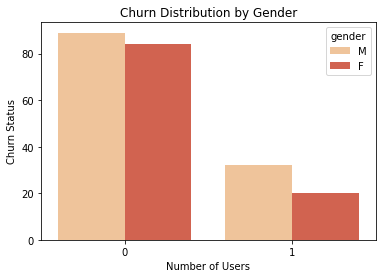

In [60]:
# plot churn by gender
pdf = df_churn.dropDuplicates(["userId", "gender"]).groupby(["churn", "gender"]).count().sort("churn").toPandas()
sns.barplot(x = 'churn', y='count', palette='OrRd', hue = 'gender', data=pdf)
plt.title("Churn Distribution by Gender")
plt.ylabel('Churn Status')
plt.xlabel('Number of Users')

In [61]:
df_churn.drop_duplicates(['userId', 'gender']).groupby(['churn', 'gender']).count().sort("churn").show()

+-----+------+-----+
|churn|gender|count|
+-----+------+-----+
|    0|     M|   89|
|    0|     F|   84|
|    1|     F|   20|
|    1|     M|   32|
+-----+------+-----+



In [62]:
# see pagen event types
df_churn.select('page').dropDuplicates().show()

+--------------------+
|                page|
+--------------------+
|              Cancel|
|    Submit Downgrade|
|         Thumbs Down|
|                Home|
|           Downgrade|
|         Roll Advert|
|              Logout|
|       Save Settings|
|Cancellation Conf...|
|               About|
|            Settings|
|     Add to Playlist|
|          Add Friend|
|            NextSong|
|           Thumbs Up|
|                Help|
|             Upgrade|
|               Error|
|      Submit Upgrade|
+--------------------+



Text(0.5,0,'Proportion of Events')

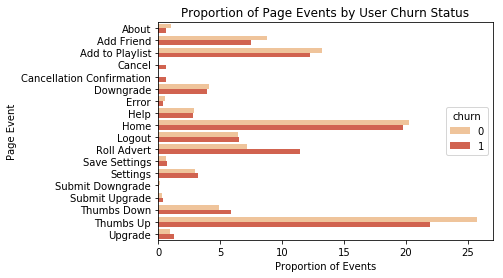

In [63]:
# plot churn by page event
df_pages = df_churn.groupby(['page','churn']).count().toPandas()
df_pages = df_pages[df_pages['page'] != 'NextSong']
df_pages = ((df_pages.groupby(['page','churn']).sum() / df_pages.groupby(['churn']).sum()) *100).reset_index()
sns.barplot(y = 'page', x = 'count', palette='OrRd', data = df_pages, hue = 'churn')
plt.title("Proportion of Page Events by User Churn Status")
plt.ylabel('Page Event')
plt.xlabel('Proportion of Events')

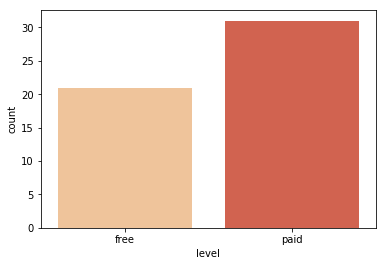

In [64]:
# plot churn by account level
df_level = df_churn.filter('page == "Cancellation Confirmation"').groupby('level').count().toPandas()
sns.barplot(x = 'level', y = 'count', palette='OrRd', data = df_level)

### Based on data for account level, it can be seen that more paid users churn than free users. This may be because users would rather pay for other apps/ pricing may be too high for sparkify. 

### Looking at the proportion of events by churn status chart, it seems like more users churn after roll advertising, Thumbs down, and thumbs up. This can be due to users disliking the amount of ads they see, or the music that they listen to. 

### More males than females churn.

# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

In [65]:
df_churn_sql = df_churn.createOrReplaceTempView("user_table")

In [66]:
# sql script to create feature list
df_training = spark.sql(
    '''
          SELECT DISTINCT 
          userId,  
          (CASE WHEN gender = 'M' THEN 0 ELSE 1 END) AS gender,
          (CASE WHEN level = 'free' THEN 0 ELSE 1 END) AS level,
          SUM(CASE WHEN page = 'Add to Playlist' THEN 1 ELSE 0 END) AS sum_add_playlist,
          SUM(CASE WHEN page = 'Downgrade' THEN 1 ELSE 0 END) AS downgrade_count,
          SUM(CASE WHEN page = 'Error' THEN 1 ELSE 0 END) AS error_count,
          SUM(CASE WHEN page = 'Help' THEN 1 ELSE 0 END) AS help_count,
          SUM(CASE WHEN page = 'Roll Advert' THEN 1 ELSE 0 END) AS roll_advert_count,
          SUM(CASE WHEN page = 'Submit Downgrade' THEN 1 ELSE 0 END) AS submit_downgrade_count,
          SUM(CASE WHEN page = 'Submit Upgrade' THEN 1 ELSE 0 END) AS submit_upgrade_count,
          SUM(CASE WHEN page = 'Thumbs Down' THEN 1 ELSE 0 END) AS thumbs_down_count,
          SUM(CASE WHEN page = 'Thumbs Up' THEN 1 ELSE 0 END) AS thumbs_up_count,
          SUM(CASE WHEN page = 'Upgrade' THEN 1 ELSE 0 END) AS upgrade_count,
          COUNT(DISTINCT song) AS total_songs,
          COUNT(DISTINCT sessionId) AS total_sessions,
          MAX(ts - registration) AS account_lifetime,
          churn
          FROM user_table
          GROUP BY userId,churn,gender,level
    ''')

df_final = df_training.toPandas()

In [67]:
print(df_final.shape)

(360, 17)


# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

In [68]:
assembler = VectorAssembler(inputCols=df_training.columns[1:-1], outputCol="FeatureVector")
features_vectored = assembler.transform(df_training)
scaler = StandardScaler(inputCol="FeatureVector", outputCol="features")
scaled = scaler.fit(features_vectored)
scaled = scaled.transform(features_vectored)

In [69]:
scaled.head()

Row(userId='300011', gender=1, level=1, sum_add_playlist=141, downgrade_count=32, error_count=2, help_count=30, roll_advert_count=3, submit_downgrade_count=1, submit_upgrade_count=0, thumbs_down_count=41, thumbs_up_count=418, upgrade_count=0, total_songs=3564, total_sessions=69, account_lifetime=5285640000, churn=0, FeatureVector=DenseVector([1.0, 1.0, 141.0, 32.0, 2.0, 30.0, 3.0, 1.0, 0.0, 41.0, 418.0, 0.0, 3564.0, 69.0, 5285640000.0]), features=DenseVector([2.0017, 2.0042, 5.4596, 3.1151, 1.7196, 5.4546, 0.1658, 2.0676, 0.0, 4.0735, 8.0289, 0.0, 4.9202, 6.7343, 1.5562]))

In [71]:
# rename columns for cross validation
df_final = scaled.select(['features', scaled['churn'].alias('label')])

In [72]:
df_final.show()

+--------------------+-----+
|            features|label|
+--------------------+-----+
|[2.00167340707005...|    0|
|[0.0,0.0,0.077440...|    0|
|[2.00167340707005...|    0|
|[2.00167340707005...|    1|
|[2.00167340707005...|    0|
|(15,[1,2,3,9,10,1...|    1|
|[0.0,2.0041914122...|    1|
|[0.0,2.0041914122...|    0|
|[2.00167340707005...|    0|
|[0.0,0.0,0.309763...|    0|
|[0.0,0.0,0.503365...|    1|
|[0.0,2.0041914122...|    0|
|[2.00167340707005...|    0|
|[2.00167340707005...|    0|
|[2.00167340707005...|    0|
|[0.0,0.0,0.425924...|    0|
|[2.00167340707005...|    0|
|(15,[0,2,5,6,10,1...|    0|
|[0.0,0.0,0.193601...|    0|
|[0.0,2.0041914122...|    0|
+--------------------+-----+
only showing top 20 rows



In [73]:
train, validation = df_final.randomSplit([0.9, 0.1], seed=42)

In [74]:
validation.count()

35

In [75]:
train.count()

325

In [79]:
# initialize the classificaton models
lr = LogisticRegression(featuresCol ='features', labelCol = 'label')
rf = RandomForestClassifier(featuresCol ='features', labelCol = 'label')
gbt = GBTClassifier(featuresCol ='features', labelCol = 'label')
svm = LinearSVC(featuresCol ='features', labelCol = 'label')

In [80]:
def train_models(model, train, validation):
    '''
    This function trains a model and predicts the target column. It also prints the f1 score.
    
    :param model: classification model to use.
    :param train: training data.
    :param validation: test data.
    '''
    clf = model.fit(train)
    pred = clf.transform(validation)
    evaluator = MulticlassClassificationEvaluator(labelCol = "label",predictionCol="prediction")
    f1score = evaluator.evaluate(pred, {evaluator.metricName: "f1"})
    print('F1 Score:{}'.format(f1score))

In [81]:
print('Linear Regression: ')
train_models(lr,train,validation)
print('Random Forest: ')
train_models(rf,train,validation)
print('Gradient Boosted Trees: ')
train_models(gbt,train,validation)
print('SVM: ')
train_models(svm,train,validation)

Linear Regression: 
F1 Score:0.6476190476190475
Random Forest: 
F1 Score:0.6387520525451561
Gradient Boosted Trees: 
F1 Score:0.6668780719835103
SVM: 
F1 Score:0.5952380952380952


### Gradient Boosted Trees model scored best, so I will hypertune its parameters to get a better result.

In [92]:
# create parameter grid and cross validator.
paramGrid = ParamGridBuilder().\
            addGrid(gbt.maxIter, [5,7,10]).\
            addGrid(gbt.maxDepth, [2,4,6]).\
            build()

crossval = CrossValidator(estimator=gbt,
                      estimatorParamMaps=paramGrid,
                      evaluator=MulticlassClassificationEvaluator(metricName="f1"),
                      numFolds=2)

In [93]:
cv_gbt = crossval.fit(train)
prediction = cv_gbt.transform(validation)

In [95]:
gbt_evaluator = MulticlassClassificationEvaluator(labelCol = "label",predictionCol="prediction")

In [97]:
gbt_f1score = gbt_evaluator.evaluate(prediction, {gbt_evaluator.metricName: "f1"})
print('F-1 Score:{}'.format(gbt_f1score))

F-1 Score:0.6387520525451561


### Here the tuned model did not perfom as well as it did before tuning, therefore I will use the model with the defualt parameters

# Final Decision
## Using Gradient Boosted Trees, my model predicts churn with an f1 score of 0.67. This model may be improved with collection of more data (maybe competition data), as well as using the larger dataset.